In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import ElementsEnv

%erun Elements 5.12.0

os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/auxdir/'

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2

from nnpz.photometry import DirectoryFilterProvider, FnuuJyPrePostProcessor, PhotometryCalculator, PhotometryWithCorrectionsCalculator
from nnpz.reference_sample.ReferenceSample import ReferenceSample

In [2]:
ref_sample = ReferenceSample('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/ProductionInputEcdmHandler/reference_sample_dir.dir/')

WARN    : Index for provider "pdz" does not follow the physical layout for file 1
2021-10-19T17:35:33CEST nnpz.reference_sample.IndexProvider  WARN : Index for provider "pdz" does not follow the physical layout for file 1
WARN    : Index for provider "sed" does not follow the physical layout for file 1
2021-10-19T17:35:33CEST nnpz.reference_sample.IndexProvider  WARN : Index for provider "sed" does not follow the physical layout for file 1
WARN    : Index for provider "sed" does not follow the physical layout for file 2
2021-10-19T17:35:33CEST nnpz.reference_sample.IndexProvider  WARN : Index for provider "sed" does not follow the physical layout for file 2
WARN    : Index for provider "sed" does not follow the physical layout for file 3
2021-10-19T17:35:33CEST nnpz.reference_sample.IndexProvider  WARN : Index for provider "sed" does not follow the physical layout for file 3
WARN    : Index for provider "sed" does not follow the physical layout for file 4
2021-10-19T17:35:33CEST nnpz.r

In [3]:
filters_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/SC8/PHZ_Calibration_28jan21/PhosphorosRootEcdmHandler/Phosphoros/AuxiliaryData/Filters/')

In [4]:
filter_map = {}
filter_names = filters_provider.getFilterNames()
for filter_name in filter_names:
    print(filter_name)
    filter_map[filter_name] = filters_provider.getFilterTransmission(filter_name)

euclid/H
euclid/Y
euclid/VIS
euclid/J
kids/r
kids/i
kids/u
kids/g
des/r
des/i
des/z
des/g
lsst/r
lsst/y
lsst/i
lsst/u
lsst/z
lsst/g


In [5]:
sed = ref_sample.getSedData(9172773410680000)
assert(sed is not None)

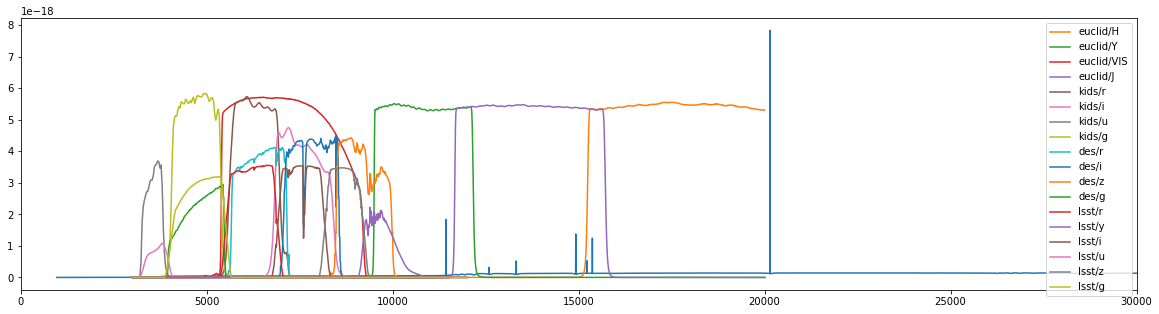

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(sed[:,0], sed[:,1])
msed = sed[:,1].max()
for fname, ftrans in filter_map.items():
    plt.plot(ftrans[:,0], ftrans[:,1]*msed, label=fname)
plt.xlim(0, 30000)
plt.legend()

In [7]:
prepost = FnuuJyPrePostProcessor(filter_map)
shifts = np.concatenate([np.arange(-100, 0), np.arange(1, 101)])
extra_shifts = np.concatenate([np.arange(-200, -100), np.arange(100, 201)])

In [8]:
calculator = PhotometryCalculator(filter_map, prepost, shifts)

In [9]:
corrector = PhotometryWithCorrectionsCalculator(filter_map, prepost, 0.3, shifts)

In [10]:
photo, raw = calculator.compute(sed)

In [11]:
_, _, corr = corrector.compute(sed)

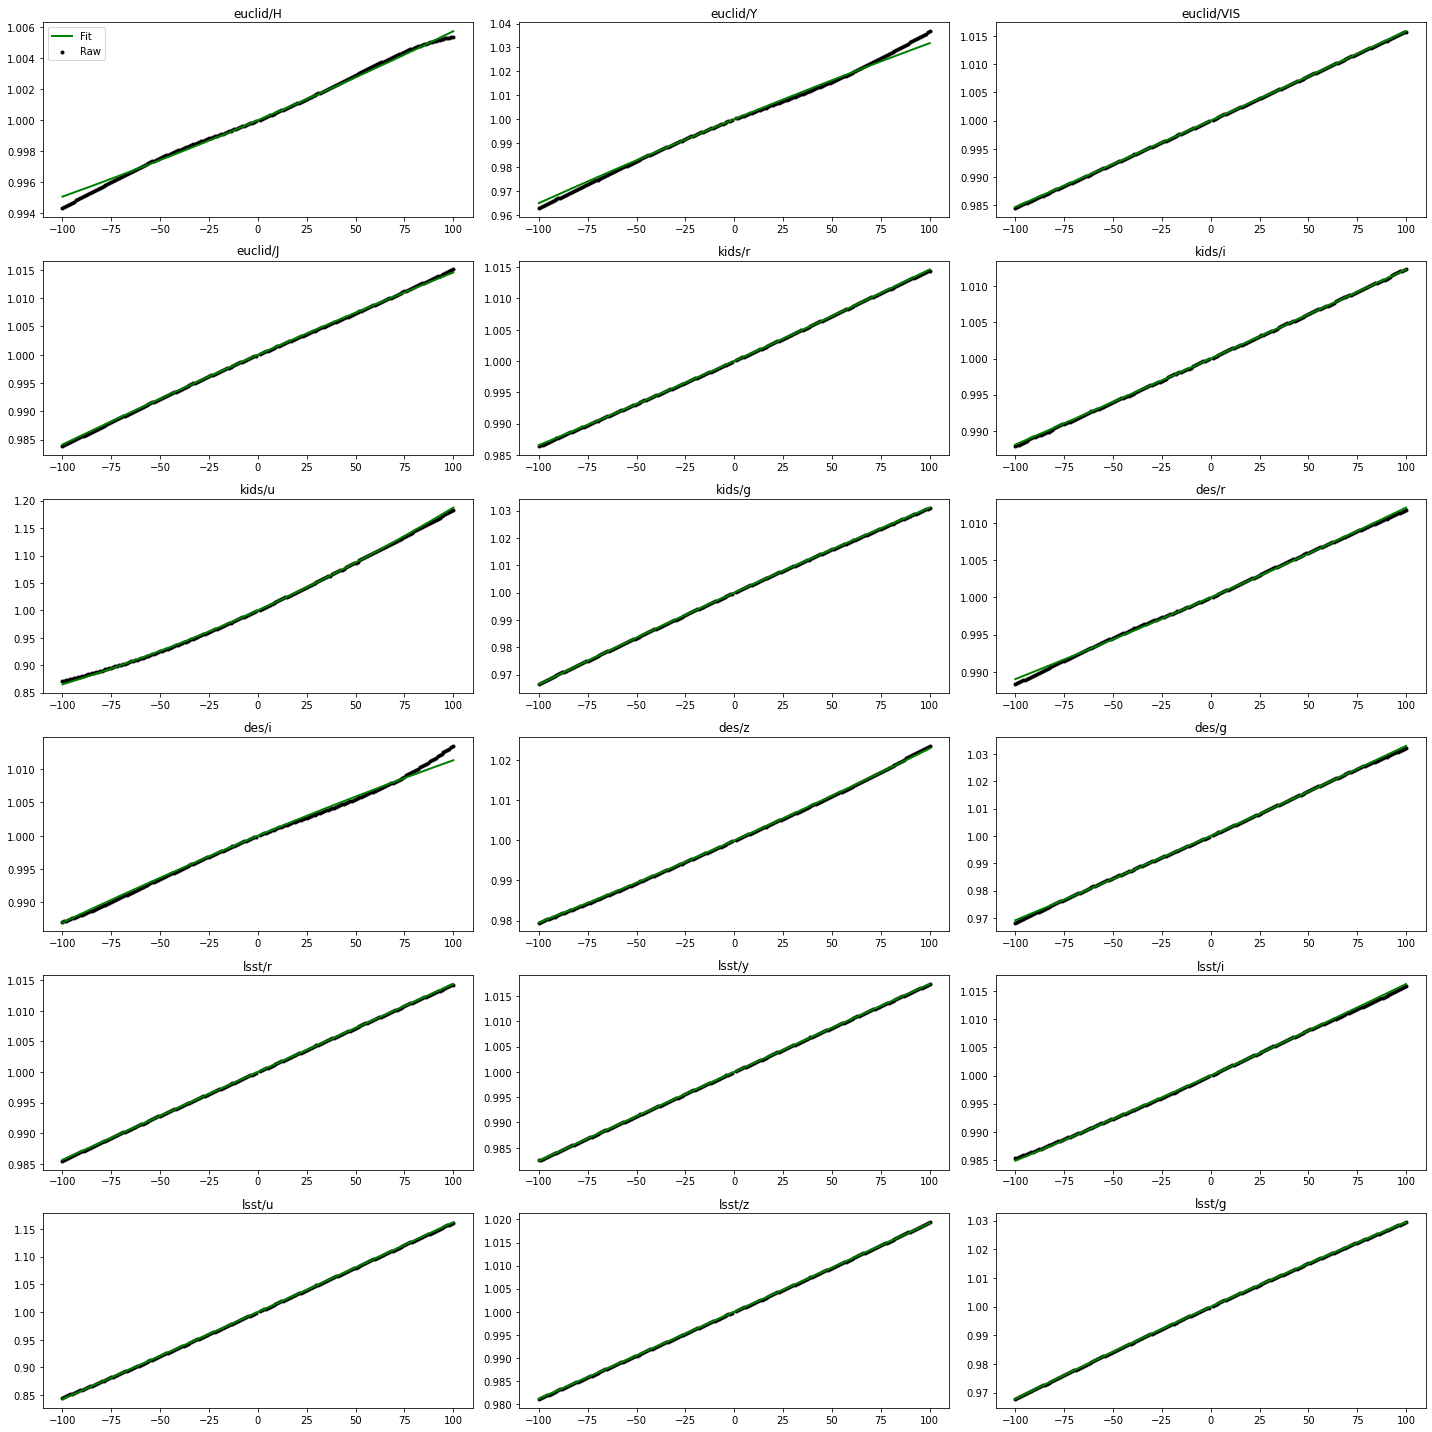

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=len(filter_map)//3, figsize=(20, 20))

for i, ax in enumerate(axes.ravel()):
    fname = filter_names[i]
    
    ax.set_title(fname)
    ax.scatter(shifts, raw[fname] / photo[fname][0], marker='.', color='black', label='Raw')
    a, b = corr[filter_names[i]]
    ax.plot(shifts, a * shifts**2 + b * shifts + 1, color='green', linestyle='-', linewidth=2, label='Fit')
    
    if i == 0:
        ax.legend()
    
plt.tight_layout()
plt.savefig('/home/aalvarez/Downloads/peaky-fixed.png')